## Textual Entailment Generation

Importing necessary modules

In [1]:
import torch 
import torch.nn as nn
from collections import Counter, OrderedDict, defaultdict
import numpy as np
import pandas as pd
import networkx as nx
import torch.nn.functional as F
from tqdm.notebook import tqdm
from ignite.metrics.nlp import Bleu
from nltk.translate import meteor_score

from string import punctuation
import re, time, math, random, itertools
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
tokenizer = get_tokenizer("basic_english")

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
%matplotlib inline
from IPython.display import clear_output

import spacy
nlp = spacy.load("en_core_web_sm")

import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

config = {"PATH" : r"D:\Huawei Share\Download", 
          "BATCH_SIZE" : 32,
          "HID_DIM" : 512,
          "N_LAYERS" : 2,
          "DROPOUT" : 0.3}

## Preparing data for the Entailment Generation task

To load and process SNLI corpus we resort to two PyTorch primitives, **Dataset** and **DataLoader**.
Dataset stores the samples, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.
We create our custom **EntailmentDataset** class which inherits from PyTorch Dataset class.
With **load_dataset** method of the EntailmentDataset class we load premise-hypothesis pairs from the SNLI corpus,
filtering for the entailment category. This method requires to specify a path to the data and a partition of the dataset to load: train, dev or test.
An instance of EntailmentDataset class is an iterable object storing data samples that can be accessed by index. Each sample is a pair of sentences, a premise and an entailed sentence respectively.

In [2]:
class EntailmentDataset(Dataset):

    def __init__(self, data):
        self.df = data
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        pair = self.df.iloc[idx]
        return pair[0], pair[1]

    @classmethod
    def load_dataset(cls, path, split):
        """Load a specified partition of the SNLI dataset
        
        Args:
        path (str): folder where the snli dataset is located
        split (str): one of "train", "dev", or "test"
        
        Returns:
        an instance of Dataset
        """
        data = pd.read_table(f"{path}\snli_1.0_{split}.txt", delimiter ="\t", index_col = "gold_label")\
             .loc[["entailment"], ["sentence1", "sentence2"]].dropna()
    
        return cls(data)

We create separate instances of EntailmentDataset class for training, developement and test data.
The training set consists of 183414 training samples, while development and test set store 3329 sentence pairs each.

In [3]:
train_data = EntailmentDataset.load_dataset(config["PATH"], split="train")
dev_data = EntailmentDataset.load_dataset(config["PATH"], split="dev")
test_data = EntailmentDataset.load_dataset(config["PATH"], split = "test")

Before we feed the data into the model, we need to apply several preprocessing steps:
* Build a vocabulary mapping each unique word in the training dataset to a unique integer.
* Tokenize and Encode the premise and hypothesis sentences into vectors of integers.
* Group data samples into minibatches to optimize the model training.

To split the sentence into tokens we develop a **word_tokenizer** function, which is built on nltk word_tokenizer function.
Additionally, our function splits words separated by dashes and removes non-alphanumeric characters from individual tokens.

To map each token into unique integer, we use **Vocab** class from torchtext package. 
We build a Vocab object from a generator function **yield_tokens**, that yields a list of tokens for each training sample. We add some special tokens to the vocabulary, such as tokens to mark the beginning and the end of the sentence: $<sos>, <eos>$.

$<unk>$ token is a placeholder for words not seen in the training data and thus not included in the vocabulary. These words are mapped to the integer 1, which is a reserved index for unknown words. Another reserved value is the integer 
0, which is assigned to padding token $<pad>$, for adjusting the sequence length.

We create **sentence2tensor** utility function to convert each sentence into a tensor of integers, according to token-integer mapping defined in the vocabulary.

In [4]:
def word_tokenizer(text):
    """ Minimal sentence cleaning and tokenization."""
    
    text = re.sub("-", " ", text)
    tokens = [w if w in punctuation else re.sub("[" + punctuation + "]", "", w) for w in tokenizer(text)]
    return tokens

def yield_tokens(data_iterator):
    """ Generator yields one list of tokens from one premise-hypothesis pair. 
    
    Args:
    train_data (str, str): training dataset
    
    Returns:
    list of tokens
    
    """
    
    for row in data_iterator:
        yield word_tokenizer(" ".join(row))
        
        
def build_vocabulary(train_data):
    """Extracts vocabulary from training data
    
    Args:
    train_data (str, str): training dataset
    
    Returns:
    vocabulary object
    """
    
    vocabulary = build_vocab_from_iterator(yield_tokens(train_data),
                                           specials = ["<unk>", "<sos>", "<eos>"])
    vocabulary.insert_token("<pad>", 0)
    vocabulary.set_default_index(vocabulary["<unk>"])
    return vocabulary

def sentence2tensor(sentence):
    """ 
    Encodes tokens with indices;
    appends <EOS> token;
    transforms into a torch.tensor.
    
    Args:
    sentence (str): row string 
    
    Returns:
    vectorized sentence
    """
    indices = [vocabulary[word] for word in word_tokenizer(sentence)]
    indices.append(vocabulary["<eos>"])
    return torch.tensor(indices)

We will generate batches of samples using **DataLoader**.
We declare a data preprocessing pipeline in **collate_batch** function, and pass it to the argument **collate_fn**.
With **collate_batch** function a batch of premise-hypothesis pairs is encoded and padding is applied to ensure that all sequences within a batch have the same length. Additionally we prepend $<sos>$ token at the begining of each hypothesis in a batch.

In [5]:
def collate_batch(batch):
    """
    Encode each pair of sentences and convert into torch.tensors;
    record the corresponding lengths for both premise and hypothesis;
    pad premise tensors to the max premise length in a batch;
    pad hypothesis tensors to the max hypothesis length in a batch.

    Args:
    A batch with premise-hypothesis pairs
    
    Returns: a dictionary 
    padded_prem: tensor with size (batch_size, max_premise_len) 
    padded_hypo: tensor with size (batch_size, 1 + max_hypothesis_len)
    premise_lengths: tensor with size (batch_size)
    hypothesis_lengths: tensor with size (batch_size)
    
    """
    premise, hypothesis, prem_lengths, hypo_lengths = [],[],[],[]
    
    for prem, hypo in batch:
        
        encode_prem = sentence2tensor(prem) # indexed tensor + eos_token
        encode_hypo = sentence2tensor(hypo) # indexed tensor + eos_token
        premise.append(encode_prem)
        hypothesis.append(encode_hypo)
        
        prem_lengths.append(encode_prem.size(0))
        hypo_lengths.append(encode_hypo.size(0))
        
        
    # padding sequences to max_sequence_length
    padded_prem = nn.utils.rnn.pad_sequence(premise, batch_first = True)
    padded_hypo = nn.utils.rnn.pad_sequence(hypothesis, batch_first = True)
    
    # prepend <sos> token to hypothesis sequences
    sos_tensor =  torch.tensor([vocabulary["<sos>"]]).repeat(padded_hypo.size(0), 1)
    padded_hypo = torch.cat((sos_tensor, padded_hypo), dim = -1)
    
    return {"premise": padded_prem,
            "hypothesis": padded_hypo,
            "premise_lengths": torch.tensor(prem_lengths),
            "hypothesis_lengths": torch.tensor(hypo_lengths)
           }

**generate_batches** function wraps the PyTorch DataLoader in order to make sure that each tensor is on the correct device. 

In [6]:
def generate_batches(dataset,
                     batch_size=32,
                     collate_fn = collate_batch,
                     shuffle=True,
                     drop_last=True,
                     device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. 
    Transfers all tensors on the correct device location.
    """
    dataloader = DataLoader(dataset=dataset, 
                            batch_size=batch_size, 
                            collate_fn = collate_fn,
                            shuffle=shuffle,
                            drop_last=drop_last)
    
    for batch_dictionary in dataloader:
        out_batch_dictionary = {}
        for name, tensor in batch_dictionary.items():
            out_batch_dictionary[name] = batch_dictionary[name].to(device)
        yield out_batch_dictionary

## Embedding for sentence encoding

We prepare an embedding layer for our model, which maps each word to a vector of real-values.
We create a look-up table by retrieving feature-vectors from a pre-trained Word2Vec model.
Each unique word in the vocabulary is assigned either a 300-dimensional pre-trained embedding or a vector of random values if there is no embedding for that word in the pre-trained Word2Vec. Word embeddings will be fine-tuned during training. The resulting embedding table has the following size: (number of tokens in vocabulary, 300).

In [7]:
def create_w2v_matrix(vocabulary, wv):
    """ Initializes an embedding matrix for vocabulary terms with word2vec pretrained vectors,
        or random vectors in case no pretrained embedding exists for a word.
    
    Args:
    vocabulary : vocabulary object
    wv : pretrained word2vec vectors
    
    Returns:
    word embedding matrix with shape (vocabulary_size, 300)
    a set of out-of-vocabulary terms
    """
    w2v_embeddings = np.zeros((len(vocabulary), 300))
    oov_set = set()
    oov_size = 0

    for word, idx in sorted(vocabulary.get_stoi().items(), key=lambda x:x[1]):
        try:
            w2v_embeddings[idx] = wv[word]
            
        except KeyError:
            oov_set.add(word)
            oov_size += 1
            w2v_embeddings[idx] = np.random.uniform(low=-np.sqrt(3), high=np.sqrt(3), size=(300,))
        
    print("Number of words not found in pretrained w2v model:", oov_size)
    w2v_embeddings = torch.Tensor(w2v_embeddings)
    return w2v_embeddings, oov_set

In [8]:
vocabulary = build_vocabulary(train_data)
len(vocabulary)

21608

In [9]:
w2v_embeddings, oov = create_w2v_matrix(vocabulary, wv)

Number of words not found in pretrained w2v model: 2619


## Building sequence-to-sequence model

A Sequence-to-sequence network is a model that utilizes two recurrent neural networks to operate on sequences. Unlike a single Recurrent Neural Network, where to each element of the input sequence corresponds an element from the output sequence, Seq2Seq network can work with input and output sequences of different length. The model consists of two components called encoder and decoder. We define a separate class for each network component.

The encoder is implemented as a bidirectional recurrent neural network with 2 layers using Long Short Term Memory units. The encoder LSTM outputs a hidden representation for each item in the input sequence. We will use term *annotations* to talk about a sequence of vector encodings for an input sentence. Thus, the role of the encoder is to encode a premise into e sequence of annotations. 


The encoder takes as inputs a batch of premise sentences and a vector specifying the actual length of each sequence in a batch. Previously, we created batches of variable length sequences, by padding each sequence to the length of the longest sequence in a batch. PyTorch provides other two utilities to perform efficient batch sequence processing: **pack_padded_sequence** and **pad_packed_sequence**. When we train RNN networks we want to avoid unnecessary computations for padded inputs. Thus, we pack padded sequences before feeding them to the recurrent layer. **pack_padded_sequence** creates a PackedSequence object, which provides an efficient data format that the RNN can read. We apply the **pad_packed_sequence** function on the packed output from the recurrent layer to convert it to the original padded output format.

The last hidden and cell states from the encoder initialize the hidden and cell state of the decoder LSTM. Before we feed the encoder network states to the decoder LSTM we have to ensure that the dimentions match. The bidirectional encoder LSTM is half the size of unidirectional decoder LSTM. Thus, we need to operate on hidden and cell encoder states to bring them to the same size of the decoder LSTM. To do this we swap the axes and group the forward and backward directions in a single dimension.

In [10]:
class Encoder(nn.Module):
    def __init__(self,
                 embed_size,
                 hidden_size,
                 n_layers,
                 dropout,
                 device):
        super().__init__()
        
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.bilstm = nn.LSTM(self.embed_size,
                              self.hidden_size,
                              num_layers = n_layers,
                              bidirectional = True,
                              batch_first = True,
                              dropout = dropout)
        
        self.dropout = nn.Dropout(p = dropout)
        
      
    def forward(self, batch, prem_length):
        # batch : [batch_size, seq_len]
        
        # premise_embedding shape: [batch_size, seq_len, 300]
        premise_embedding = self.dropout(batch)
        
        # Handling padding in Recurrent Networks
        prem_packed = nn.utils.rnn.pack_padded_sequence(premise_embedding,
                                                        prem_length.cpu(),
                                                        enforce_sorted = False,
                                                        batch_first = True)
        
        # lstm_state is a tuple (hidden, cell) with size : [4, batch_size, 256] 
        # lstm_out with size : [batch_size, seq_len, 512]
        lstm_out, lstm_state = self.bilstm(prem_packed)  
        
        # pad lstm output to have same length sequences in batch
        annotations = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)[0] 
        
        # resize from [num_layers * n_directions, batch_size, hidden] to [num_layers, batch_size, hidden * 2]
        hidden = lstm_state[0].reshape(self.n_layers, 2, -1, self.hidden_size)\
            .transpose(1,2).reshape(self.n_layers, -1, 2*self.hidden_size)
        cell = lstm_state[1].reshape(self.n_layers, 2, -1, self.hidden_size)\
            .transpose(1,2).reshape(self.n_layers, -1, 2*self.hidden_size)

        # hidden and cell of size [num_layers, batch_size, hidden] = [2, 32, 512]
        # annotations of size [batch_size, seq_len, 512] 
        return annotations, (hidden, cell)

### Decoder without attention

In a base Seq2Seq model without attention, the decoder is another recurrent neural network that uses the final state from encoder network, called context vector, to initialize its hidden state. Conceptually, the context vector represents a summary of the input sentence. The role of the decoder is to generate an entailed sentence conditioned on the information from the contextualized vector representation of a premise.
Differently from the encoder network, we implement the decoder with a 2-layer unidirectional LSTM. It takes as inputs a batch of hypotheses, a vector of the corresponding sequence lengths and the hidden and cell states from the encoder.
The decoder network without attention is similar to the encoder network described above, except for a fully connected layer with sotfmax activation, which takes the output from the decoder LSTM and converts it into a vector of log probabilities.


In [ ]:
class Decoder(nn.Module):
    def __init__(self,
                 pretrained_w2v,
                 hidden_size,
                 n_layers, 
                 dropout,
                 device
                 ):
        super().__init__()
        self.num_classes = pretrained_w2v[0]
        self.embed_size = pretrained_w2v[1]
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(self.embed_size,
                            self.hidden_size,
                            num_layers = n_layers,
                            batch_first = True, 
                            dropout = dropout)
        
        self.W_s = nn.Linear(self.hidden_size, self.num_classes, bias = True)
        self.dropout = nn.Dropout(dropout)
    
        
    def forward(self, hypothesis_batch, hypo_len, prev_state):
        # hypothesis_batch with shape [batch_size, seq_len]
        # hypo_len with shape [batch_size]
        # prev_state with shape ([2, 32, 512], [2, 32, 512])
        
        hypothesis_embedding = self.dropout(hypothesis_batch)
        # hypothesis_embedding with shape [batch_size, seq_len, 300]
        
        # Handling padding in Recurrent Networks
        hypo_packed = nn.utils.rnn.pack_padded_sequence(hypothesis_embedding,
                                                        hypo_len.cpu(),
                                                        enforce_sorted = False,
                                                        batch_first = True)
        
        # lstm_state with shape [num_layers, batch_size, hidden_dim] = [2, 32, 512]
        lstm_out, lstm_state = self.lstm(hypo_packed, prev_state) 
        
        # unpacked_lstm_out = [batch_size, seq_len, hidden_dim] = [32, seq_len, 512]
        unpacked_lstm_out = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first = True)[0] 
        
        # probabilities with shape [batch_size x seq_len, vocab_size]
        log_probs = F.log_softmax(self.W_s(unpacked_lstm_out), dim = -1)
        return log_probs, lstm_state

The Seq2Seq class incorporates both the encoder and decoder networks. First, the sequences are embedded with an embedding layer. Then, the input feature vectors are fed to the encoder. We take the last hidden state from the final encoder LSTM and pass it as initial hidden state to the decoder LSTM. We apply *teacher forcing* method to speed up the training. That is, we use the ground truth from the output sequence as inputs instead of the actual model predictions.

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 pretrained_w2v,
                 hidden_size,
                 n_layers,
                 dropout = 0.2,
                 device = "cpu" ):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings = pretrained_w2v,
                                                      freeze = False,
                                                      padding_idx = 0)
        
        self.encoder = Encoder(pretrained_w2v.size(1),
                               hidden_size//2,
                               n_layers,
                               dropout,
                               device)
        self.decoder = Decoder(pretrained_w2v.size(),
                               hidden_size,
                               n_layers,
                               dropout,
                               device)
        self.device = device
        
    def forward(self, premise, hypothesis, prem_length, hypo_length):
        
        hypothesis = hypothesis[:,:-1].contiguous()
        
        # Embdedding
        prem_embed = self.embedding(premise)
        hypo_embed = self.embedding(hypothesis)
        
        # Encoding & Decoding
        _, encoder_state = self.encoder(prem_embed, prem_length)
        log_probs, decoder_state = self.decoder(hypo_embed,
                                                hypo_length,
                                                encoder_state)
        return log_probs

## Decoder with Attention

With the base Seq2Seq model a unique context vector is passed between the encoder and decoder, whereas with attention mechanism we allow the decoder to define a new context vector at each decoding step, attending to any subset of positions from the encoded input sequence.
 We add an attention layer on top of the decoder LSTM. This layer takes as inputs the output from the decoder LSTM, **hidden_decoder**, and a sequence of annotations from the encoder. The output of this layer is the attention distribution and a context vector for the current decoding step. 
 
 By default our **Decoder** class implements dot-product attention mechanism, where attention weights are computed using dot-product compatibility function between encoder and decoder hidden states. Another way to compute attention distribution is to use a feed-forward layer. We implement this second method with a separate class, called **AdditiveAttention**.  With additive attention the decoder and encoder outputs are first transformed into query and key vectors respectively. Keys and query are concatenated and passed through another fully connected layer with softmax activation to obtain the attention weights. When computing attention distribution over the input sequence we mask the positions corresponding to $<pad>$ token. The padding inputs are filled with large negative values so that the model pays zero attention to the corresponfing positions. The **attention_weights** are muliplied with encoder annotations(values) to produce a context vector for the current decoding step, **expected_annotation**.

In [11]:
class AdditiveAttention(nn.Module):
    
    def __init__(self, query_size, key_size, hid_dim, dropout):
        super().__init__()
        self.W_k = nn.Linear(key_size, hid_dim, bias = False)
        self.W_q = nn.Linear(query_size, hid_dim, bias = False)
        self.W_v = nn.Linear(hid_dim, 1, bias = False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, hidden_decoder, annotations, mask = None):
        query, keys = self.W_q(hidden_decoder), self.W_k(annotations)
        # features (tensor) with shape: (batch_size, nquery, nkeys, 512) 
        features = query.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(self.dropout(features))
        energy = self.W_v(features).squeeze(-1)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        attention_weights = F.softmax(energy, dim = -1)
        expected_annotation = torch.bmm(attention_weights, annotations)
        
        # attention_weights shape: [batch_size, hypo_len, prem_len]
        # expected_annotation shape: [batch_size, hypo_len, hidden_size]
        return attention_weights, expected_annotation.to(device)

In [12]:
class Decoder(nn.Module):
    def __init__(self,
                 embedding_matrix_size,
                 hidden_size,
                 n_layers,
                 dropout,
                 device,
                 additive_attention = False
                 ):
        super().__init__()
        self.num_classes = embedding_matrix_size[0]
        self.embed_size = embedding_matrix_size[1]
        self.hidden_size = hidden_size
        self.additive_attention = additive_attention

        self.lstm = nn.LSTM(self.embed_size,
                            self.hidden_size,
                            num_layers = n_layers,
                            batch_first = True, 
                            dropout = dropout)
        
        self.W_a = nn.Linear(self.hidden_size + self.hidden_size , self.hidden_size, bias = True)
        self.W_s = nn.Linear(self.hidden_size, self.num_classes, bias = True)
        self.dropout = nn.Dropout(dropout)
        if additive_attention:
            self.additive_attention_layer = AdditiveAttention(query_size=self.hidden_size,
                                                              key_size=self.hidden_size,
                                                              hid_dim=self.hidden_size//2,
                                                              dropout=dropout)
        
    def dot_attention_layer(self, hidden_decoder, annotations, mask = None):
        # hidden_decoder shape: [batch_size, hypo_len, hidden_size]
        # annotations shape: [batch_size, prem_len, hidden_size]
        # mask shape: [batch_size, 1, prem_len]
        
        # energy shape: [batch_size, hypo_len, prem_len]   
        energy = torch.bmm(hidden_decoder, annotations.permute(0,2,1))
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        attention_weights = F.softmax(energy, dim = -1)
        expected_annotation = torch.bmm(attention_weights, annotations)
        
        # attention_weights shape: [batch_size, hypo_len, prem_len]
        # expected_annotation shape: [batch_size, hypo_len, hidden_size]
        return attention_weights, expected_annotation
        
    def forward(self, hypothesis_batch, hypo_len, annotations, prev_state, mask = None):
        # hypothesis_batch shape: [batch_size, hypo_len]
        # annotations shape: [batch_size, hypo_len, hidden_size]
        # prev_state shape: ([2, 32, 512], [2, 32, 512])
        # mask(optional) shape: [batch_size, 1, prem_len]
        
        # hypothesis_embedding shape: [batch_size, hypo_len, 300]
        hypothesis_embedding = self.dropout(hypothesis_batch)
        
        # Handling padding in Recurrent Networks
        hypo_packed = nn.utils.rnn.pack_padded_sequence(hypothesis_embedding,
                                                        hypo_len.cpu(),
                                                        enforce_sorted = False,
                                                        batch_first = True)
        
        # lstm_state shape: [num_layers, batch_size, hidden_size] 
        lstm_output, lstm_state = self.lstm(hypo_packed, prev_state) 
        
        # lstm_output shape: [batch_size, hypo_len, hidden_size] 
        lstm_output = nn.utils.rnn.pad_packed_sequence(lstm_output, batch_first = True)[0] 
        
        # attention_weights shape: [batch_size, hypo_len, prem_len]
        # expected_annotation shape: [batch_size, hypo_len, hidden_size]
        if self.additive_attention:
            attention_weights, expected_annotation = self.additive_attention_layer(hidden_decoder=lstm_output,
                                                                                        annotations=annotations,
                                                                                        mask=mask)
        else:           
            attention_weights, expected_annotation = self.dot_attention_layer(hidden_decoder=lstm_output,
                                                                                   annotations=annotations, 
                                                                                   mask=mask)
        # attention_hidden shape: [batch_size, hypo_len, hidden_size]
        context_vector = torch.cat((expected_annotation, lstm_output), dim = -1)
        attention_hidden = self.dropout(torch.tanh(self.W_a(context_vector)))
        
        # probabilities shape: [batch_size, hypo_len, vocab_size]
        log_probs = F.log_softmax(self.W_s(attention_hidden), dim = -1)
        return log_probs, lstm_state, attention_weights

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 pretrained_w2v,
                 hidden_size,
                 n_layers,
                 dropout = 0.2,
                 device = "cpu",
                 additive_attention = False):
        super().__init__()
        self.device = device
        self.embedding = nn.Embedding.from_pretrained(embeddings = pretrained_w2v,
                                                      freeze = False,
                                                      padding_idx = 0)
        
        self.encoder = Encoder(pretrained_w2v.size(1),
                               hidden_size//2,
                               n_layers,
                               dropout,
                               device)
        self.decoder = Decoder(pretrained_w2v.size(),
                               hidden_size,
                               n_layers,
                               dropout,
                               device,
                               additive_attention)

    @staticmethod
    def create_mask(seq):    
        # seq shape: [batch_size, seq_len]
        # mask shape: [batch_size, 1, seq_len]
    
        mask = (seq != 0).unsqueeze(1)
        return mask

        
    def forward(self, premise, hypothesis, prem_length, hypo_length):
        
        prem_mask = Seq2Seq.create_mask(premise).to(device)
        hypothesis = hypothesis[:,:-1].contiguous()
        
        # Embdedding
        prem_embed = self.embedding(premise)
        hypo_embed = self.embedding(hypothesis)
        
        #Encoding & Decoding
        encoder_output, encoder_state = self.encoder(prem_embed,
                                                     prem_length)
        log_probs, decoder_state, _ = self.decoder(hypo_embed,
                                                   hypo_length,
                                                   encoder_output,
                                                   encoder_state, 
                                                   prem_mask)
        return log_probs

## Train Seq2Seq model

We define a couple of utility functions for model training. **train** function performs a loop over the training data, processing one batch at a time. For each batch of data, we apply the Seq2Seq model and obtain vectors with predictions. We measure the loss between predicted values and ground truth, using negative log-likelihood loss function. Given the loss value we compute the gradients. We perform gradient clipping before updating the model parameters. **evaluate** function applies the model to validation data and computes the validation loss. We observe the training progress plotting the average training loss every 100 iterations, while the avarage epoch loss on training and validation set is reported at the end of each epoch. In order to make our experiments reproducible, we set a seed and randomly initialize the model parameters, except for the embedding layer which holds pre-trained word2vec vectors. We train the model for a specified number of epochs.

In [14]:
def count_parameters(model):
    """ Counts the number of learnable parameters in the model"""
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

def init_weights(model):
    """ Initializes weights of the model (except for pretrained embeddings) 
        with random values in a predefined interval. """
    for name, param in model.named_parameters():
        if name != "embedding.weight":
            nn.init.uniform_(param, -0.08, 0.08)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [16]:
def train(model,
          train_data,
          optimizer,
          criterion, 
          device,
          train_history=None, valid_history=None):
    
    model.train()
    iteration, epoch_loss = 0, 0
    history = []

    for batch_dictionary in tqdm(generate_batches(train_data, device = device)):  
        
        iteration += 1
        
        # reset gradients
        model.zero_grad()
                
        # compute output 
        log_probs = model(*batch_dictionary.values())
        num_classes = log_probs.size(-1) 
        
        # compute loss for a batch
        batch_loss = criterion(log_probs.view(-1, num_classes), 
                               batch_dictionary["hypothesis"][:,1:].contiguous().view(-1))
        epoch_loss += batch_loss.item()
        batch_loss.backward()
        
        # clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        
        # update parameters
        optimizer.step()
        
        # logging and reporting
        history.append( epoch_loss / iteration )
        
        if iteration % 100 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='training history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='validation history')
            plt.legend()
            plt.show()
            
    return epoch_loss / iteration

In [ ]:
def evaluate(model, dev_data, criterion, device):
    
    model.eval()
    epoch_loss, iteration = 0, 0
    
    with torch.no_grad():
    
        for batch_dictionary in tqdm(generate_batches(dev_data, device = device)):  
        
            iteration += 1
            
            # reset gradients
            model.zero_grad()
                    
            # compute probability distribution over vocabulary
            log_probs = model(*batch_dictionary.values())
            num_classes = log_probs.size(-1) 
            
            # compute loss for a batch
            batch_loss = criterion(log_probs.view(-1, num_classes), 
                                   batch_dictionary["hypothesis"][:, 1:].contiguous().view(-1))
            epoch_loss += batch_loss.item()            
    
        return epoch_loss / iteration

In [15]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"You are using {device} device")

model = Seq2Seq(pretrained_w2v = w2v_embeddings,
                hidden_size = config["HID_DIM"],
                n_layers = config["N_LAYERS"],
                dropout = config["DROPOUT"],
                device = device,
                additive_attention = True)

model = model.to(device)
model.apply(init_weights)
print(f'The seq2seq model has {count_parameters(model):,} trainable parameters')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss(ignore_index = 0)

You are using cuda device
The seq2seq model has 24,842,568 trainable parameters


In [ ]:
torch.cuda.empty_cache()

train_history = []
valid_history = []
N_EPOCHS = 3


for epoch in range(N_EPOCHS):
    
    start_time = time.time()

    train_loss = train(model, train_data, optimizer, criterion, device, train_history, valid_history)
    valid_loss = evaluate(model, dev_data, criterion, device)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} ')
    print(f'\t Val. Loss: {valid_loss:.3f} ')

In [16]:
checkpoint = torch.load(r"D:\Huawei Share\Download\inPROGRESS\Attention_additive_layer.tar")
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
model = model.to(device)

## Evaluation and Visualization

Once the model was trained, we evaluate its peformance on the test data. We define **predict** function that takes a premise and a model and implements greedy decoding to generate an entailed sentence. The input sentence is converted to a tensor of indices with **sentence2tensor** utility function. The resulting tensor is embedded and encoded with the encoder network. **greedy-decoder** takes the final encoder network states and a sequence of annotations as inputs. The function first initiates the hidden decoder state with hidden state from encoder and starts to decode the entailed sentence. We set to 20 the maximum lenght of the output sentence and pass in the $<sos>$ to start the generation process. At each decoding step the decoder outputs a vector of probability distribution over vocabulary terms, the hidden state of the network and the attention distribution. The word with maximum predicted probability is selected as the next input word. The process is repeated until we reach the maximum sequence lenght or the model outputs the $<eos>$ token. At this point the generation stops, and the function returns the decoded sentence and a matrix of attention weights.

In [17]:
def greedy_decoder(model, annotations, encoder_hidden):
    """ Generates a hypothesis for a given premise.
    Args:
    model: trained seq2seq model
    annotations: tensor with shape (1, premise_len, hidden_size) 
    encoder_hidden: tensor with shape (2, 1, hidden_size) 

    Returns:
    decoded_hypothesis: str
    attention_weights: array with size (hypothesis_len, premise_len)
    """
    
    # initiate decoder hidden_state with encoder final hidden state
    decoder_hidden = encoder_hidden

    # create a tensor for <sos> token and a tensor for token length
    token_len = torch.tensor([1]).to(device)
    input_word = torch.tensor([vocabulary["<sos>"]]).view(1, 1).to(device)
  
    decoded_hypothesis, attention_weigths = [], []
    
    # start to decode a sequence of at most 20 tokens
    for step in range(20):

        # embed a word of the target sequence
        decoder_input = model.embedding(input_word)
        
        # compute probability distribution, hidden state, and attention
        probabilities, decoder_hidden, att_weight = model.decoder(decoder_input, token_len, annotations, decoder_hidden)
        attention_weigths.append(att_weight.squeeze().cpu().numpy())
        
        # decode the word with max probability score, stop if it is <eos> token
        _, topi = probabilities.data.topk(1)
        topi = topi.view(-1)
        decoded_word = vocabulary.lookup_tokens([int(topi)])[0]
        if decoded_word == "<eos>":
            break
    
        input_word = topi.detach().view(-1, 1)
        decoded_hypothesis.append(decoded_word)

    return " ".join(decoded_hypothesis), np.array(attention_weigths) 


def predict(premise, model): 
     
    """ Implements greedy decoding to generate the entailed sentence for a given premise.
      Args:
      premise: str
      model: seq2seq model
    
      Returns:
      entailed_sentence: str
      attention_weights: array with size (hypothesis_len, premise_len)
      """
    
    premise_tensor = sentence2tensor(premise).view(1, -1).to(device)
    premise_len = torch.tensor([premise_tensor.size(1)]).to(device)
    
    model.eval()
    
    with torch.no_grad():
        # embed premise
        premise_tensor = model.embedding(premise_tensor)
        
        # retrieve contextual representation of premise(annotations) and the final hidden state
        annotations, hidden_enc = model.encoder(premise_tensor, premise_len)
        
        # generate the hypothesis and compute attention weights
        entailed_sentence, att_weights = greedy_decoder(model, annotations, hidden_enc)
        
    return entailed_sentence, att_weights

### Evaluation with RoBERTa and quantitative metrics

We employ two quantitative metrics to evaluate the entailment generated with Seq2Seq model:
* *Bleu* metric from *ignite.metrics.nlp* module, and
* *meteor_score* from *nltk.translate* module.

BLEU metric takes as inputs pre-tokenized hypothesis and a list of pre-tokenized references.

METEOR metric instead operates on raw sentences. It expects a list of references and a predicted hypothesis as inputs.

We preliminary group the gold hypotheses in the test set by the corresponding premise to create a set of reference hypotheses for each premise. **reference_hypotheses** is a set of sentences agains which we evaluate the generated hypothesis.
We adopt two evaluation approaches. The first approach builds a set of reference hypotheses from the gold hypotheses associated with a specific premise. Whereas the second approach also includes the premise into the reference set.

To evaluate the semantic accuracy of entailed sentences we import a pretrained Roberta Transformer model for sequence classification and measure the percentage of correctly entailed sentences produced with our model. RoBERTa takes in input a pair of sentences and outputs an index corresponding to a semantic label, describing logical relation between two sentences. We define a map to convert indeces to the corresponding semantic labels.

In [18]:
# group together hypotheses associated with a given premise
grouped_test_data = defaultdict(list)
for premise, hypothesis in test_data:
    grouped_test_data[premise.lower()].append(hypothesis.lower())
    
# create a map from indices to semantic labels
mapping = { 0: "contradiction", 1:"neutral", 2: "entailment"}

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
RobertaTokenizer = RobertaTokenizer.from_pretrained('roberta-large-mnli')
RobertaModel = RobertaForSequenceClassification.from_pretrained('roberta-large-mnli')

def roberta_classify(premise, generated_hypo):
    # adapted from https://github.com/ufal/nlgi_eval/blob/master/nli_eval.py
    
    inputs = RobertaTokenizer("%s </s></s> %s" % (premise, generated_hypo), return_tensors="pt")
    labels = torch.tensor([1]).unsqueeze(0)  # create a batch_dim of 1
    output = RobertaModel(**inputs, labels=labels) # output contains loss, logits
    
    probs = F.softmax(output[1], dim=1).detach().numpy()[0]
    return  probs # [contradiction, neutral, entailment]

In [ ]:
bleu = Bleu(ngram = 1)
semantic_accuracy = 0
bleu_scores, bleu_scores_extended, meteor, meteor_extended, false_entailment = [], [], [], [], []

for index, sample in enumerate(grouped_test_data.items()):
    print("Sample n.", index)
    premise, reference_hypotheses = sample

    # generate the entailed sentence with Seq2Seq model
    pred_hypothesis, att_weights = predict(premise, model)
    print("> Premise:", premise, sep = "\n")
    print("> Generated hypothesis:", pred_hypothesis)
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # Calculate BLEU score:
    
    # pre-tokenize hypothesis and references    
    tokens_prediction = pred_hypothesis.split()
    tokens_reference_set = list(map(word_tokenizer, reference_hypotheses))
    tokens_reference_set_extended = list(map(word_tokenizer, [premise] + reference_hypotheses))
    
    # 1st approach : BLEU
    bleu.update(([tokens_prediction], [tokens_reference_set]))
    bleu_score = bleu.compute().item()
    bleu_scores.append(bleu_score)
    bleu.reset()
    print()
    print("Bleu score:", bleu_score)
    
    # 2nd approach : BLEU
    bleu.update(([tokens_prediction], [tokens_reference_set_extended]))
    bleu_score = bleu.compute().item()
    bleu_scores_extended.append(bleu_score)
    bleu.reset()
    print("Bleu score with premise:", bleu_score)
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # Calculate METEOR score for hypothesis with multiple references
    
    # 1st approach
    meteor_sent =  meteor_score.meteor_score(reference_hypotheses, pred_hypothesis, gamma = 0)
    meteor.append(meteor_sent) 
    print("Meteor score:", meteor_sent)
    
    # 2nd approach
    meteor_sent =  meteor_score.meteor_score([premise] + reference_hypotheses, pred_hypothesis, gamma = 0)
    meteor_extended.append(meteor_sent) 
    print("Meteor score with premise:", meteor_sent)
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # use ROBERTA to check if a generated hypothesis is entailed in a premise
    classification_roBERTa = np.argmax(roberta_classify(premise, tokens_prediction))
 
    if classification_roBERTa != 2 :
        entailment_check = 0
        false_entailment.append((index, premise, tokens_prediction))
    else: 
        entailment_check = 1
        
    print("Classified as:", mapping[classification_roBERTa])
    semantic_accuracy += entailment_check
    
    print("__________________________________________________________")  
    
print("Macro-Average precision with sentence-level Blue score:", np.mean(bleu_scores)*100)
print("Macro-Average precision with sentence-level Blue score 2nd approach:", np.mean(bleu_scores_extended)*100)
print("Average METEOR score:", np.mean(meteor)*100)
print("Average METEOR score 2nd approach:", np.mean(meteor_extended)*100)
print("Semantic accuracy", (semantic_accuracy / index)*100 )

### Visualizing attention

We can display attention weights using **display_attention**. This function plots a heat map of attention values, with premise on the columns and entailed sentence on the rows.
The white color indicates high attention value, whereas back denotes zero attention.
Another way to represent attention is to build a bipartite graph where the entailed sentence is projected onto the input sentence.  We create **draw_alignment** function that graphically illustrates the alignment between two sentences.
The edges connecting input and output words represent attention weights. The arrow color and width denote the attention strenght. Bright green indicates maximum attention value, whereas white color stands for zero attention. We can specify a threshold on attention value to visualize only attention weights above a predefined value. Additionally, we can replace word labels with part-of-speech tags or syntactic dependencies and inspect the attention behaviour from syntactic prespective.

In [22]:
def display_attention(premise, hypothesis, attention):
    fig, ax = plt.subplots(figsize =(15,30))
    cax = ax.matshow(attention, cmap='bone')
    
    # Set up axes
    ax.tick_params(labelsize =16)
    ax.set_xticklabels([""] + word_tokenizer(premise) + ['<EOS>'], rotation=60)
    ax.set_yticklabels( [""] + hypothesis.split(" ")+['<EOS>'])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Sample n. 0


<ipython-input-22-bb79bcd8576c>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + word_tokenizer(premise) + ['<EOS>'], rotation=60)
<ipython-input-22-bb79bcd8576c>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels( [""] + hypothesis.split(" ")+['<EOS>'])


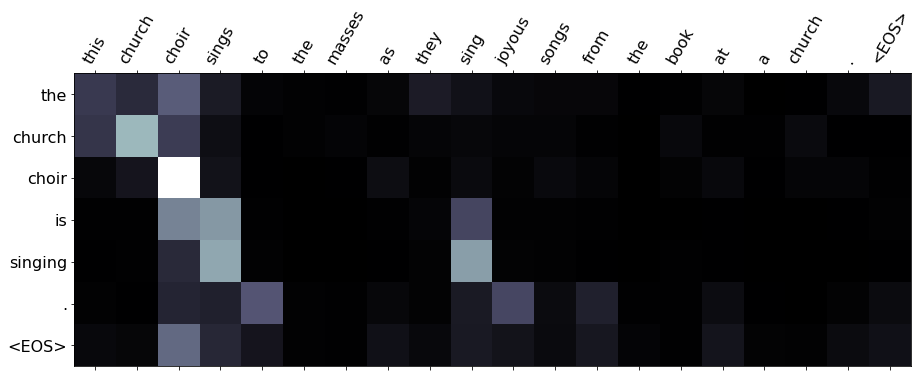

Sample n. 1


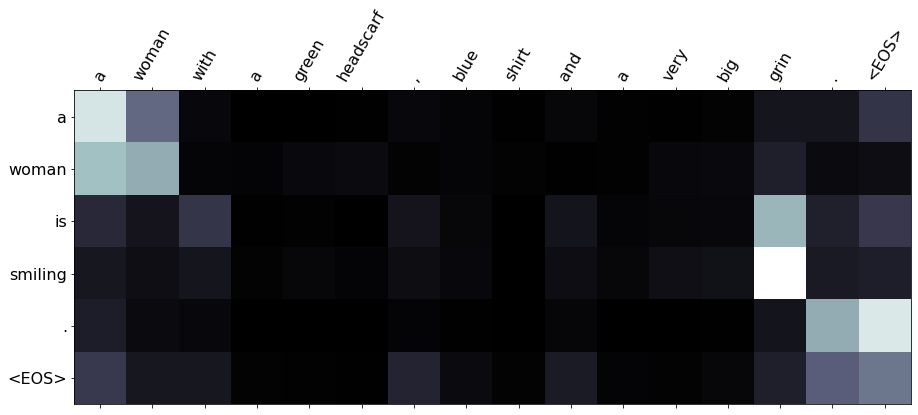

Sample n. 2


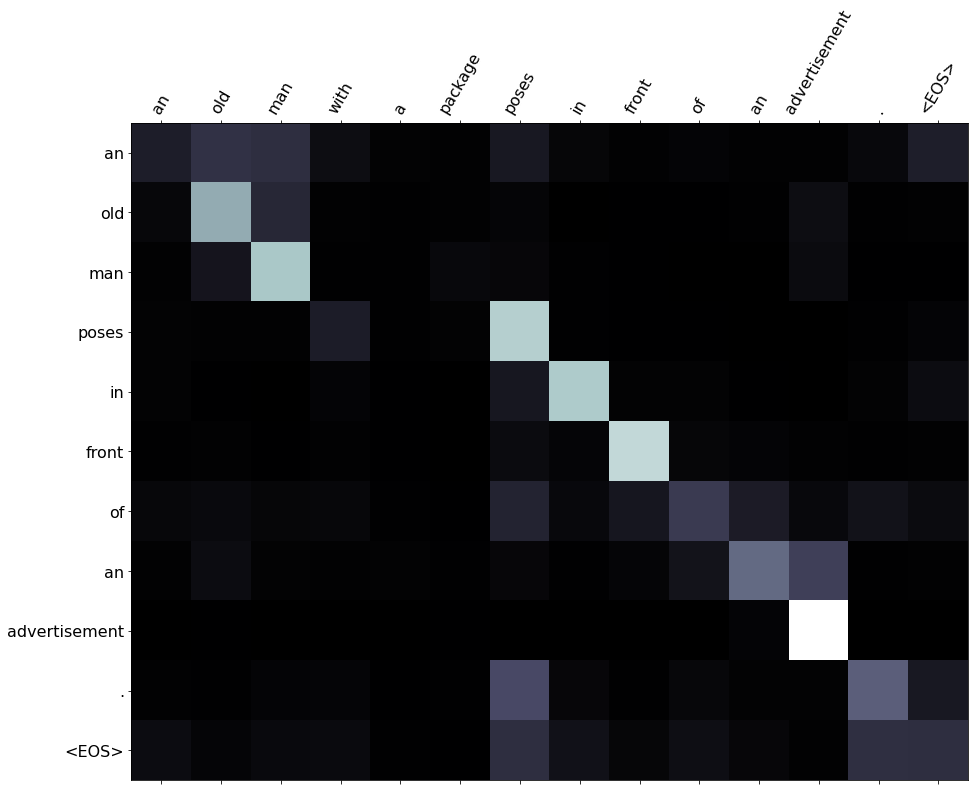

In [23]:
for index in range(3):
    print("Sample n.", index)
    premise, hypothesis = test_data[index]

    # predict the corresponding hypothesis
    pred_hypothesis, att_weights = predict(premise, model)
    display_attention(premise, pred_hypothesis, att_weights)

In [30]:
def draw_alignment(premise, decoded_hypothesis, attention_weights, THRESHOLD_ATTENTION = 0.0, tag = None):
               
    #- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # DEFINE THE BIPARTITE GRAPH 
    
    def get_source_target_labels(PREM, HYPO, tag = tag):
        # PREM : str
        # HYPO : str
        PREM = " ".join(word_tokenizer(PREM))
        if tag == None:
            tokenized_prem = PREM.split() + ['<eos>']
            tokenized_hypo = HYPO.split() + ['<eos>']
            return tokenized_prem, tokenized_hypo
        
        elif tag == "pos_tag":
            pos_prem = [tok.pos_ for tok in nlp(PREM)] + ['<eos>']
            pos_hypo = [tok.pos_ for tok in nlp(HYPO)] + ['<eos>']
            return pos_prem, pos_hypo
        
        elif tag == "dep_tag":
            dep_prem = [tok.dep_ for tok in nlp(PREM)] + ['<eos>']
            dep_hypo = [tok.dep_ for tok in nlp(HYPO)] + ['<eos>']
            return dep_prem, dep_hypo
    
    src_labels, trg_labels = get_source_target_labels(premise, decoded_hypothesis)
    
    G = nx.DiGraph()
    
    # specify indices of nodes for tokens in premise and hypothesis
    nodes_source = range(1, len(src_labels) + 1)
    nodes_target = range(len(src_labels) + 1, len(src_labels + trg_labels) + 1)
    
    # add nodes to the graph
    G.add_nodes_from(nodes_source, bipartite = "src")
    G.add_nodes_from(nodes_target, bipartite = "trg") 
    
    # add word attribute to source and target nodes
    nx.set_node_attributes(G, dict(zip(G.nodes, src_labels)), "word")
    for i, node in enumerate(nodes_target):
        G.nodes[node]["word"] = trg_labels[i]   
    
    # retrieve words to set labels for nodes in the graph
    # labels : dict {1: 'this', 2: 'church', 3: 'choir', 4: 'sings',... }
    labels = nx.get_node_attributes(G, 'word')
    
    # add edges with weights represented by attention score
    edge_w = []
    for i, trg in enumerate(nodes_target):
        for j, src in enumerate(nodes_source):
            if attention_weights[i,j] > THRESHOLD_ATTENTION:
                edge_w.append(attention_weights[i,j])
                G.add_edge(trg, src, weight=attention_weights[i,j])
    
    # specify a bipartite layout and correct misalignment in target sentence      
    pos = nx.bipartite_layout(G, nodes_target, align = "horizontal", scale = 10, aspect_ratio = 5/2)
    new_pos_list = []
    for node_idx in nodes_target:
        new_pos_list.append(pos[node_idx])
    new_pos_list = sorted(new_pos_list, key= lambda x:x[0])
    for node_idx, coord in zip(nodes_target, new_pos_list):
        pos[node_idx] = coord
     
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # DRAW THE NETWORK
    
    fig, ax = plt.subplots(figsize=(16, 4))
    
    # inflate attention weights in terms of arrow width
    edge_wts = [20.0 * edge for edge in edge_w]
    
    # choose the colormap
    # plt.colormaps() check out for colormaps
    cm = plt.cm.ocean_r
    
    # draw round-corner boxes around words
    # fc = facecolor of the box, ec = edgecolor of the box 
    bb = dict(boxstyle="round,pad=0.3", fc="w", ec="green", alpha=0.8, mutation_scale=10)
    
    # Visualize graph components
    nx.draw_networkx_edges(G, pos, alpha=0.9, width=edge_wts, edge_color=edge_wts, edge_cmap = cm, arrowstyle = "wedge",  arrowsize = 30, connectionstyle='arc3')
    nx.draw_networkx_nodes(G, pos, node_size= 0.5, node_color="#210070", alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=18, bbox=bb, labels = labels)
    
    # Normalize color values (default is in 0-1)
    norm = matplotlib.colors.Normalize(vmin=THRESHOLD_ATTENTION, vmax=1)
        
    # creating ScalarMappable for colorbar
    sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
    sm.set_array([]) 
    plt.colorbar(sm)
    
    # Resize figure for label readibility
    ax.margins(x = 0.01, y = 0.09)
    fig.tight_layout()
    plt.axis("off")
    plt.show()
    #fig.savefig("alignments_pos3.png", bbox_inches='tight')

Sample n. 608


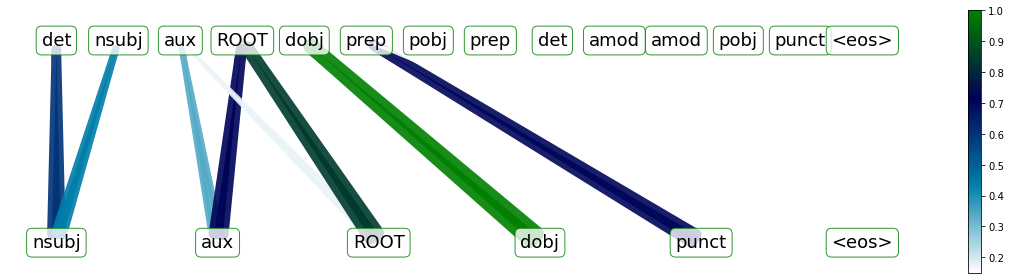

Sample n. 373


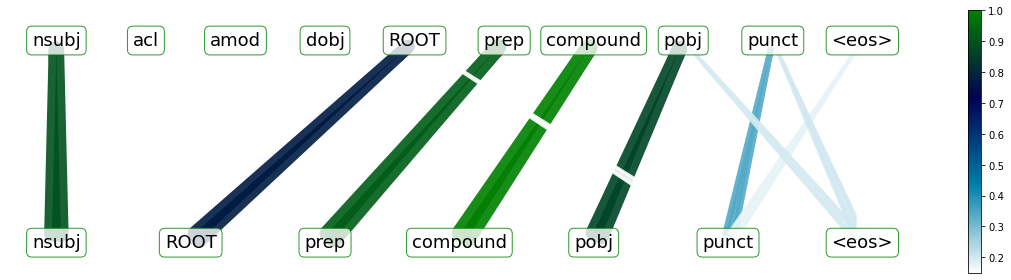

Sample n. 749


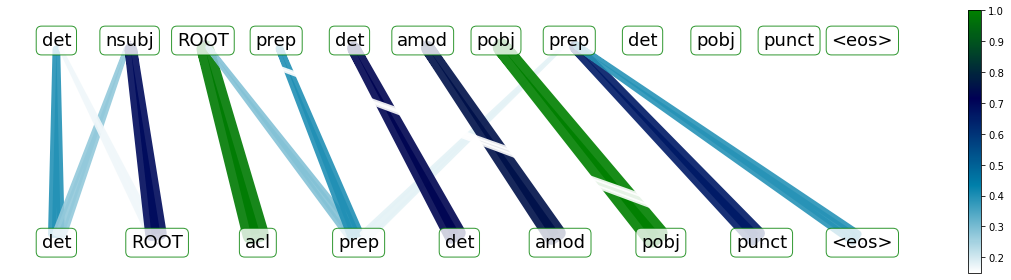

Sample n. 2922


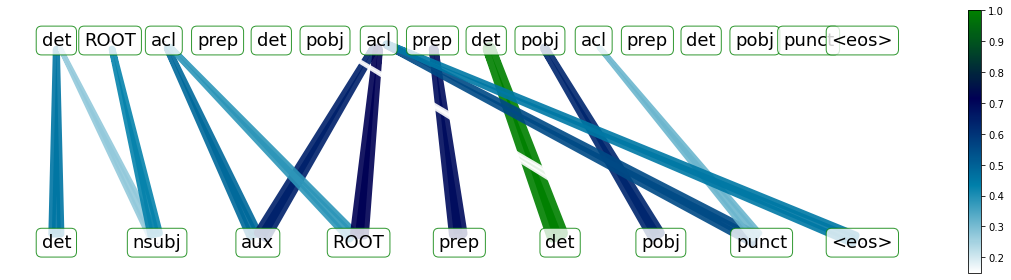

Sample n. 468


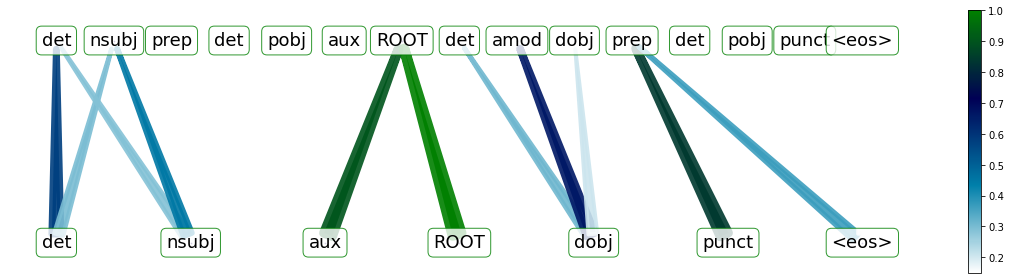

In [33]:
for index in random.sample(range(len(test_data)), k=5):
    print("Sample n.", index)
    premise, hypothesis = test_data[index]

    # generate hypothesis
    pred_hypothesis, att_weights = predict(premise, model)
    draw_alignment(premise, pred_hypothesis, att_weights, THRESHOLD_ATTENTION=0.15, tag="dep_tag")